# IMC-solution

## Dependencies and imports

In [1]:
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl

!mkdir -p pretrained/checkpoints
!cp /kaggle/input/imc2022-dependencies/pretrained/dkm.pth pretrained/checkpoints/dkm_base_v11.pth

!pip install -f /kaggle/input/imc2022-dependencies/wheels --no-index einops
!cp -r /kaggle/input/imc2022-dependencies/DKM/ /kaggle/working/DKM/
!cd /kaggle/working/DKM/; pip install -f /kaggle/input/imc2022-dependencies/wheels -e . 

!cp -a ../input/super-glue-pretrained-network ./
!mv ./super-glue-pretrained-network/models ./super-glue-pretrained-network/models_superglue

Processing /kaggle/input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
  Attempting uninstall: kornia
    Found existing installation: kornia 0.5.8
    Uninstalling kornia-0.5.8:
      Successfully uninstalled kornia-0.5.8
Processing /kaggle/input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
Looking in links: /kaggle/input/imc2022-dependencies/wheels
Processing /kaggle/input/imc2022-dependencies/wheels/einops-0.4.1-py3-none-any.whl
Looking in links: /kaggle/input/imc2022-dependencies/wheels
Obtaining file:///kaggle/working/DKM
  Preparing metadata (setup.py) ... - done
  Running setup.py develop for dkm


In [2]:
import sys
sys.path.append('../input/einops')
sys.path.append('/kaggle/input/imc2022-dependencies/DKM/')
sys.path.append('../input/aslfeat')
sys.path.append("./super-glue-pretrained-network")

In [3]:
import os
import gc
import cv2
import csv
import time
import math
import random

from glob import glob
from tqdm import tqdm
from collections import namedtuple

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image

import yaml

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import kornia as K
import kornia.feature as KF
from kornia_moons.feature import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import ResNet
from torchvision.models import resnet as tv_resnet
from torchvision.transforms.functional import InterpolationMode

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from einops import rearrange
from models import get_model
from models_superglue.matching import Matching
from models_superglue.utils import (compute_pose_error, compute_epipolar_error,
                          estimate_pose, make_matching_plot,
                          error_colormap, AverageTimer, pose_auc, read_image,
                          rotate_intrinsics, rotate_pose_inplane,
                          scale_intrinsics)

## DKM code

The reason of placing it here is that I forced to rewrite it in some places in order to fix image resizing in the model itself.

In [4]:
def get_tuple_transform_ops(resize=None, normalize=True, unscale=False):
    ops = []
    if resize:
        ops.append(TupleResize(resize))
    if normalize:
        ops.append(TupleToTensorScaled())
        ops.append(
            TupleNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        )  # Imagenet mean/std
    else:
        if unscale:
            ops.append(TupleToTensorUnscaled())
        else:
            ops.append(TupleToTensorScaled())
    return TupleCompose(ops)


class ToTensorScaled(object):
    """Convert a RGB PIL Image to a CHW ordered Tensor, scale the range to [0, 1]"""

    def __call__(self, im):
        if not isinstance(im, torch.Tensor):
            im = np.array(im, dtype=np.float32).transpose((2, 0, 1))
            im /= 255.0
            return torch.from_numpy(im)
        else:
            return im

    def __repr__(self):
        return "ToTensorScaled(./255)"


class TupleToTensorScaled(object):
    def __init__(self):
        self.to_tensor = ToTensorScaled()

    def __call__(self, im_tuple):
        return [self.to_tensor(im) for im in im_tuple]

    def __repr__(self):
        return "TupleToTensorScaled(./255)"


class ToTensorUnscaled(object):
    """Convert a RGB PIL Image to a CHW ordered Tensor"""

    def __call__(self, im):
        return torch.from_numpy(np.array(im, dtype=np.float32).transpose((2, 0, 1)))

    def __repr__(self):
        return "ToTensorUnscaled()"


class TupleToTensorUnscaled(object):
    """Convert a RGB PIL Image to a CHW ordered Tensor"""

    def __init__(self):
        self.to_tensor = ToTensorUnscaled()

    def __call__(self, im_tuple):
        return [self.to_tensor(im) for im in im_tuple]

    def __repr__(self):
        return "TupleToTensorUnscaled()"


class TupleResize(object):
    def __init__(self, size, mode=InterpolationMode.BICUBIC):
        self.size = size
        self.resize = transforms.Resize(size, mode)

    def __call__(self, im_tuple):
        return [self.resize(im) for im in im_tuple]

    def __repr__(self):
        return "TupleResize(size={})".format(self.size)


class TupleNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.normalize = transforms.Normalize(mean=mean, std=std)

    def __call__(self, im_tuple):
        return [self.normalize(im) for im in im_tuple]

    def __repr__(self):
        return "TupleNormalize(mean={}, std={})".format(self.mean, self.std)


class TupleCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, im_tuple):
        for t in self.transforms:
            im_tuple = t(im_tuple)
        return im_tuple

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        for t in self.transforms:
            format_string += "\n"
            format_string += "    {0}".format(t)
        format_string += "\n)"
        return format_string


class ConvRefiner(nn.Module):
    def __init__(
        self,
        in_dim=6,
        hidden_dim=16,
        out_dim=2,
        bicubic_gradients=False,
        dw=False,
        residual=False,
        groups=1,
        kernel_size=5,
        hidden_blocks=3,
        weight_norm=False,
    ):
        super().__init__()
        self.block1 = self.create_block(
            in_dim, hidden_dim, dw=dw, groups=groups, kernel_size=kernel_size
        )
        self.hidden_blocks = nn.Sequential(
            *[
                self.create_block(
                    hidden_dim,
                    hidden_dim,
                    dw=dw,
                    groups=groups,
                    kernel_size=kernel_size,
                    weight_norm=weight_norm,
                )
                for hb in range(hidden_blocks)
            ]
        )
        self.out_conv = nn.Conv2d(hidden_dim, out_dim, 1, 1, 0)
        self.bicubic_gradients = bicubic_gradients
        self.residual = residual

    def create_block(
        self,
        in_dim,
        out_dim,
        dw=False,
        kernel_size=5,
        groups=1,
        residual=False,
        weight_norm=False,
    ):
        num_groups = 1 if not dw else in_dim
        if dw:
            assert (
                out_dim % in_dim == 0
            ), "outdim must be divisible by indim for depthwise"
        conv1 = nn.Conv2d(
            in_dim,
            out_dim,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2,
            groups=num_groups,
        )
        norm = nn.BatchNorm2d(out_dim)
        relu = nn.ReLU(inplace=True)
        conv2 = nn.Conv2d(out_dim, out_dim, 1, 1, 0)
        return nn.Sequential(conv1, norm, relu, conv2)

    def forward(self, x, y, flow):
        """Computes the relative refining displacement in pixels for a given image x,y and a coarse flow-field between them
        Args:
            x ([type]): [description]
            y ([type]): [description]
            flow ([type]): [description]
        Returns:
            [type]: [description]
        """
        if self.bicubic_gradients:
            x_hat = F.grid_sample(y, flow.permute(0, 2, 3, 1), align_corners=False)
        else:
            with torch.no_grad():
                x_hat = F.grid_sample(
                    y, flow.permute(0, 2, 3, 1), align_corners=False
                )  # Propagating gradients through grid_sample seems to be unstable :/
        d = torch.cat((x, x_hat), dim=1)
        d = self.block1(d)
        d = self.hidden_blocks(d)
        d = self.out_conv(d)
        certainty, displacement = d[:, :-2], d[:, -2:]
        return certainty, displacement


class CosKernel(nn.Module):  # similar to softmax kernel
    def __init__(self, T, learn_temperature=False):
        super().__init__()
        self.learn_temperature = learn_temperature
        if self.learn_temperature:
            self.T = nn.Parameter(torch.tensor(T))
        else:
            self.T = T

    def __call__(self, x, y, eps=1e-6):
        c = torch.einsum("bnd,bmd->bnm", x, y) / (
            x.norm(dim=-1)[..., None] * y.norm(dim=-1)[:, None] + eps
        )
        if self.learn_temperature:
            T = self.T.abs() + 0.01
        else:
            T = torch.tensor(self.T, device=c.device)
        K = ((c - 1.0) / T).exp()
        return K


class CAB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CAB, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.sigmod = nn.Sigmoid()

    def forward(self, x):
        x1, x2 = x  # high, low (old, new)
        x = torch.cat([x1, x2], dim=1)
        x = self.global_pooling(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmod(x)
        x2 = x * x2
        res = x2 + x1
        return res


class RRB(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(RRB, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2,
        )
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size // 2,
        )

    def forward(self, x):
        x = self.conv1(x)
        res = self.conv2(x)
        res = self.bn(res)
        res = self.relu(res)
        res = self.conv3(res)
        return self.relu(x + res)


class DFN(nn.Module):
    def __init__(
        self,
        internal_dim,
        feat_input_modules,
        pred_input_modules,
        rrb_d_dict,
        cab_dict,
        rrb_u_dict,
        use_global_context=False,
        global_dim=None,
        terminal_module=None,
        upsample_mode="bilinear",
        align_corners=False,
    ):
        super().__init__()
        if use_global_context:
            assert (
                global_dim is not None
            ), "Global dim must be provided when using global context"
        self.align_corners = align_corners
        self.internal_dim = internal_dim
        self.feat_input_modules = feat_input_modules
        self.pred_input_modules = pred_input_modules
        self.rrb_d = rrb_d_dict
        self.cab = cab_dict
        self.rrb_u = rrb_u_dict
        self.use_global_context = use_global_context
        if use_global_context:
            self.global_to_internal = nn.Conv2d(global_dim, self.internal_dim, 1, 1, 0)
            self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.terminal_module = (
            terminal_module if terminal_module is not None else nn.Identity()
        )
        self.upsample_mode = upsample_mode
        self._scales = [int(key) for key in self.terminal_module.keys()]

    def scales(self):
        return self._scales.copy()

    def forward(self, new_stuff, feats, old_stuff, key):
        feats = self.feat_input_modules[str(key)](feats)
        new_stuff = torch.cat([feats, new_stuff], dim=1)
        new_stuff = self.rrb_d[str(key)](new_stuff)
        new_old_stuff = self.cab[str(key)](
            [old_stuff, new_stuff]
        )  # TODO: maybe use cab output upwards in network instead of rrb_u?
        new_old_stuff = self.rrb_u[str(key)](new_old_stuff)
        preds = self.terminal_module[str(key)](new_old_stuff)
        pred_coord = preds[:, -2:]
        pred_certainty = preds[:, :-2]
        return pred_coord, pred_certainty, new_old_stuff


class GP(nn.Module):
    def __init__(
        self,
        kernel,
        T=1,
        learn_temperature=False,
        only_attention=False,
        gp_dim=64,
        basis="fourier",
        covar_size=5,
        only_nearest_neighbour=False,
        sigma_noise=0.1,
        no_cov=False,
    ):
        super().__init__()
        self.K = kernel(T=T, learn_temperature=learn_temperature)
        self.sigma_noise = sigma_noise
        self.covar_size = covar_size
        self.pos_conv = torch.nn.Conv2d(2, gp_dim, 1, 1)
        self.only_attention = only_attention
        self.only_nearest_neighbour = only_nearest_neighbour
        self.basis = basis
        self.no_cov = no_cov

    def get_local_cov(self, cov):
        K = self.covar_size
        b, h, w, h, w = cov.shape
        hw = h * w
        cov = F.pad(cov, 4 * (K // 2,))  # pad v_q
        delta = torch.stack(
            torch.meshgrid(
                torch.arange(-(K // 2), K // 2 + 1), torch.arange(-(K // 2), K // 2 + 1)
            ),
            dim=-1,
        )
        positions = torch.stack(
            torch.meshgrid(
                torch.arange(K // 2, h + K // 2), torch.arange(K // 2, w + K // 2)
            ),
            dim=-1,
        )
        neighbours = positions[:, :, None, None, :] + delta[None, :, :]
        points = torch.arange(hw)[:, None].expand(hw, K**2)
        local_cov = cov.reshape(b, hw, h + K - 1, w + K - 1)[
            :,
            points.flatten(),
            neighbours[..., 0].flatten(),
            neighbours[..., 1].flatten(),
        ].reshape(b, h, w, K**2)
        return local_cov

    def reshape(self, x):
        return rearrange(x, "b d h w -> b (h w) d")

    def project_to_basis(self, x):
        if self.basis == "fourier":
            return torch.cos(8 * math.pi * self.pos_conv(x))
        else:
            raise ValueError(
                "No other bases other than fourier currently supported in public release"
            )

    def get_pos_enc(self, y):
        b, c, h, w = y.shape
        coarse_coords = torch.meshgrid(
            (
                torch.linspace(-1 + 1 / h, 1 - 1 / h, h, device=y.device),
                torch.linspace(-1 + 1 / w, 1 - 1 / w, w, device=y.device),
            )
        )

        coarse_coords = torch.stack((coarse_coords[1], coarse_coords[0]), dim=-1)[
            None
        ].expand(b, h, w, 2)
        coarse_coords = rearrange(coarse_coords, "b h w d -> b d h w")
        coarse_embedded_coords = self.project_to_basis(coarse_coords)
        return coarse_embedded_coords

    def forward(self, x, y, **kwargs):
        b, c, h, w = y.shape
        f = self.get_pos_enc(y)
        b, d, h, w = f.shape
        assert x.shape == y.shape
        x, y, f = self.reshape(x), self.reshape(y), self.reshape(f)
        K_xx = self.K(x, x)
        K_yy = self.K(y, y)
        K_xy = self.K(x, y)
        K_yx = K_xy.permute(0, 2, 1)
        sigma_noise = self.sigma_noise * torch.eye(h * w, device=x.device)[None, :, :]
        K_yy_inv = torch.linalg.inv(K_yy + sigma_noise)

        mu_x = K_xy.matmul(K_yy_inv.matmul(f))
        mu_x = rearrange(mu_x, "b (h w) d -> b d h w", h=h, w=w)
        if not self.no_cov:
            cov_x = K_xx - K_xy.matmul(K_yy_inv.matmul(K_yx))
            cov_x = rearrange(cov_x, "b (h w) (r c) -> b h w r c", h=h, w=w, r=h, c=w)
            local_cov_x = self.get_local_cov(cov_x)
            local_cov_x = rearrange(local_cov_x, "b h w K -> b K h w")
            gp_feats = torch.cat((mu_x, local_cov_x), dim=1)
        else:
            gp_feats = mu_x
        return gp_feats


class Encoder(nn.Module):
    def __init__(self, resnet):
        super().__init__()
        self.resnet = resnet

    def forward(self, x):
        x0 = x

        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x1 = self.resnet.relu(x)

        x = self.resnet.maxpool(x1)
        x2 = self.resnet.layer1(x)

        x3 = self.resnet.layer2(x2)

        x4 = self.resnet.layer3(x3)

        x5 = self.resnet.layer4(x4)

        return {32: x5, 16: x4, 8: x3, 4: x2, 2: x1, 1: x0}


class Decoder(nn.Module):
    def __init__(self, embedding_decoder, gps, proj, conv_refiner, detach=False, scales="all"):
        super().__init__()
        self.embedding_decoder = embedding_decoder
        self.gps = gps
        self.proj = proj
        self.conv_refiner = conv_refiner
        self.detach = detach
        if scales == "all":
            self.scales = ["32", "16", "8", "4", "2", "1"]
        else:
            self.scales = scales

    def upsample_preds(self, flow, certainty, query, support):
        b, hs, ws, d = flow.shape
        b, c, h, w = query.shape

        flow = flow.permute(0, 3, 1, 2)
        certainty = F.interpolate(
            certainty, size=query.shape[-2:], align_corners=False, mode="bilinear"
        )
        flow = F.interpolate(
            flow, size=query.shape[-2:], align_corners=False, mode="bilinear"
        )
        for k in range(3):
            delta_certainty, delta_flow = self.conv_refiner["1"](query, support, flow)
            boi = delta_certainty.sigmoid()
            delta_flow = boi * delta_flow
            flow = torch.stack(
                (
                    flow[:, 0] + delta_flow[:, 0] / (4 * w),
                    flow[:, 1] + delta_flow[:, 1] / (4 * h),
                ),
                dim=1,
            )
            certainty = (
                certainty + delta_certainty
            )  # predict both certainty and displacement
        flow = flow.permute(0, 2, 3, 1)
        return flow, certainty

    def get_placeholder_flow(self, b, h, w, device):
        coarse_coords = torch.meshgrid(
            (
                torch.linspace(-1 + 1 / h, 1 - 1 / h, h, device=device),
                torch.linspace(-1 + 1 / w, 1 - 1 / w, w, device=device),
            )
        )
        coarse_coords = torch.stack((coarse_coords[1], coarse_coords[0]), dim=-1)[
            None
        ].expand(b, h, w, 2)
        coarse_coords = rearrange(coarse_coords, "b h w d -> b d h w")
        return coarse_coords

    def forward(self, f1, f2):
        """[summary]
        Args:
            f1:
            f2:
        Returns:
            dict:
                scale (s32,s16,s8,s4,s2,s1):
                    dense_flow: (b,n,h_scale,w_scale)
                    dense_certainty: (b,h_scale,w_scale,2)
        """
        coarse_scales = self.embedding_decoder.scales()
        all_scales = self.scales
        sizes = {scale: f1[scale].shape[-2:] for scale in f1}
        h, w = sizes[1]
        b = f1[32].shape[0]
        device = f1[32].device
        old_stuff = torch.zeros(
            b, self.embedding_decoder.internal_dim, *sizes[32], device=f1[32].device
        )
        dense_corresps = {}
        dense_flow = self.get_placeholder_flow(b, *sizes[32], device)
        dense_certainty = 0.0

        for new_scale in all_scales:
            ins = int(new_scale)
            f1_s, f2_s = f1[ins], f2[ins]

            if new_scale in self.proj:
                f1_s, f2_s = self.proj[new_scale](f1_s), self.proj[new_scale](f2_s)

            if ins in coarse_scales:
                old_stuff = F.interpolate(
                    old_stuff, size=sizes[ins], mode="bilinear", align_corners=False
                )
                new_stuff = self.gps[new_scale](f1_s, f2_s, dense_flow=dense_flow)
                dense_flow, dense_certainty, old_stuff = self.embedding_decoder(
                    new_stuff, f1_s, old_stuff, new_scale
                )

            if new_scale in self.conv_refiner:
                delta_certainty, displacement = self.conv_refiner[new_scale](
                    f1_s, f2_s, dense_flow
                )  # TODO: concat dense certainty?
                dense_flow = torch.stack(
                    (
                        dense_flow[:, 0] + ins * displacement[:, 0] / (4 * w),
                        dense_flow[:, 1] + ins * displacement[:, 1] / (4 * h),
                    ),
                    dim=1,
                )  # multiply with scale
                dense_certainty = (
                    dense_certainty + delta_certainty
                )  # predict both certainty and displacement

            dense_corresps[ins] = {
                "dense_flow": dense_flow,
                "dense_certainty": dense_certainty,
            }

            if new_scale != "1":
                dense_flow = F.interpolate(
                    dense_flow,
                    size=sizes[ins // 2],
                    align_corners=False,
                    mode="bilinear",
                )

                dense_certainty = F.interpolate(
                    dense_certainty,
                    size=sizes[ins // 2],
                    align_corners=False,
                    mode="bilinear",
                )
                if self.detach:
                    dense_flow = dense_flow.detach()
                    dense_certainty = dense_certainty.detach()
        return dense_corresps


class RegressionMatcher(nn.Module):
    def __init__(
        self,
        encoder,
        decoder,
        h=384,
        w=512,
    ):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.w_resized = w
        self.h_resized = h
        self.og_transforms = get_tuple_transform_ops(resize=None, normalize=True)

    def extract_backbone_features(self, batch):
        x_q = batch["query"]
        x_s = batch["support"]
        X = torch.cat((x_q, x_s))
        feature_pyramid = self.encoder(X)
        return feature_pyramid
    
    def sample(self, dense_matches, dense_certainty, num = 200, relative_confidence_threshold = 0.0):
        matches, certainty = (
            dense_matches.reshape(-1, 4).cpu().numpy(),
            dense_certainty.reshape(-1).cpu().numpy(),
        )
        relative_confidence = certainty/certainty.max()
        matches, certainty = (
            matches[relative_confidence > relative_confidence_threshold],
            certainty[relative_confidence > relative_confidence_threshold],
        )
        good_samples = np.random.choice(
            np.arange(len(matches)),
            size=min(num, len(certainty)),
            replace=False,
            p=certainty/np.sum(certainty),
        )
        return matches[good_samples], certainty[good_samples]

    def forward(self, batch):
        feature_pyramid = self.extract_backbone_features(batch)
        f_q_pyramid = {
            scale: f_scale.chunk(2)[0] for scale, f_scale in feature_pyramid.items()
        }
        f_s_pyramid = {
            scale: f_scale.chunk(2)[1] for scale, f_scale in feature_pyramid.items()
        }
        dense_corresps = self.decoder(f_q_pyramid, f_s_pyramid)
        return dense_corresps

    def forward_symmetric(self, batch):
        feature_pyramid = self.extract_backbone_features(batch)
        f_q_pyramid = feature_pyramid
        f_s_pyramid = {
            scale: torch.cat((f_scale.chunk(2)[1], f_scale.chunk(2)[0]))
            for scale, f_scale in feature_pyramid.items()
        }
        dense_corresps = self.decoder(f_q_pyramid, f_s_pyramid)
        return dense_corresps

    def cycle_constraint(self, query_coords, query_to_support, support_to_query):
        dist = query_coords - F.grid_sample(
            support_to_query, query_to_support, mode="bilinear"
        )
        return dist

    def stable_neighbours(self, query_coords, query_to_support, support_to_query):
        qts = query_to_support
        for t in range(4):
            _qts = qts
            q = F.grid_sample(support_to_query, qts, mode="bilinear")
            qts = F.grid_sample(
                query_to_support.permute(0, 3, 1, 2),
                q.permute(0, 2, 3, 1),
                mode="bilinear",
            ).permute(0, 2, 3, 1)
        d = (qts - _qts).norm(dim=-1)
        qd = (q - query_coords).norm(dim=1)
        stabneigh = torch.logical_and(d < 1e-3, qd < 5e-3)
        return q, qts, stabneigh

    def match(
        self,
        im1,
        im2,
        w_resize,
        h_resize,
        batched=False,
        check_cycle_consistency=False,
        do_pred_in_og_res=False,
    ):
        self.w_resized = w_resize
        self.h_resized = h_resize
        self.train(False)
        with torch.no_grad():
            if not batched:
                b = 1
                w, h = im1.size
                w2, h2 = im2.size
                # Get images in good format
                ws = self.w_resized
                hs = self.h_resized
                test_transform = get_tuple_transform_ops(
                    resize=(hs, ws), normalize=True
                )
                query, support = test_transform((im1, im2))
                batch = {"query": query[None].cuda(), "support": support[None].cuda()}
            else:
                b, c, h, w = im1.shape
                b, c, h2, w2 = im2.shape
                assert w == w2 and h == h2, "wat"
                batch = {"query": im1.cuda(), "support": im2.cuda()}
                hs, ws = self.h_resized, self.w_resized
            finest_scale = 1  # i will assume that we go to the finest scale (otherwise min(list(dense_corresps.keys())) also works)
            # Run matcher
            if check_cycle_consistency:
                dense_corresps = self.forward_symmetric(batch)
                query_to_support, support_to_query = dense_corresps[finest_scale][
                    "dense_flow"
                ].chunk(2)
                query_to_support = query_to_support.permute(0, 2, 3, 1)
                dense_certainty, dc_s = dense_corresps[finest_scale][
                    "dense_certainty"
                ].chunk(
                    2
                )  # TODO: Here we could also use the reverse certainty
            else:
                dense_corresps = self.forward(batch)
                query_to_support = dense_corresps[finest_scale]["dense_flow"].permute(
                    0, 2, 3, 1
                )
                # Get certainty interpolation
                dense_certainty = dense_corresps[finest_scale]["dense_certainty"]

            if do_pred_in_og_res:  # Will assume that there is no batching going on.
                og_query, og_support = self.og_transforms((im1, im2))
                query_to_support, dense_certainty = self.decoder.upsample_preds(
                    query_to_support,
                    dense_certainty,
                    og_query.cuda()[None],
                    og_support.cuda()[None],
                )
                hs, ws = h, w
            # Create im1 meshgrid
            query_coords = torch.meshgrid(
                (
                    torch.linspace(-1 + 1 / hs, 1 - 1 / hs, hs, device="cuda:0"),
                    torch.linspace(-1 + 1 / ws, 1 - 1 / ws, ws, device="cuda:0"),
                )
            )
            query_coords = torch.stack((query_coords[1], query_coords[0]))
            query_coords = query_coords[None].expand(b, 2, hs, ws)
            dense_certainty = dense_certainty.sigmoid()  # logits -> probs
            if check_cycle_consistency:
                query_coords, query_to_support, stabneigh = self.stable_neighbours(
                    query_coords, query_to_support, support_to_query
                )
                dense_certainty *= stabneigh.float() + 1e-3
            # Return only matches better than threshold
            query_coords = query_coords.permute(0, 2, 3, 1)

            query_to_support = torch.clamp(query_to_support, -1, 1)
            if batched:
                return torch.cat((query_coords, query_to_support), dim=-1), dense_certainty[:, 0]
            else:
                return torch.cat((query_coords, query_to_support), dim=-1)[0], dense_certainty[0, 0]

In [5]:
dkm_pretrained_urls = {"base": {"v11":"https://github.com/Parskatt/storage/releases/download/dkm/dkm_base_v11.pth"}, "v1": ""}


def dkm_base(pretrained=True, version="v11"):
    gp_dim = 256
    dfn_dim = 384
    feat_dim = 256
    coordinate_decoder = DFN(
        internal_dim=dfn_dim,
        feat_input_modules=nn.ModuleDict(
            {
                "32": nn.Conv2d(512, feat_dim, 1, 1),
                "16": nn.Conv2d(512, feat_dim, 1, 1),
            }
        ),
        pred_input_modules=nn.ModuleDict(
            {
                "32": nn.Identity(),
                "16": nn.Identity(),
            }
        ),
        rrb_d_dict=nn.ModuleDict(
            {
                "32": RRB(gp_dim + feat_dim, dfn_dim),
                "16": RRB(gp_dim + feat_dim, dfn_dim),
            }
        ),
        cab_dict=nn.ModuleDict(
            {
                "32": CAB(2 * dfn_dim, dfn_dim),
                "16": CAB(2 * dfn_dim, dfn_dim),
            }
        ),
        rrb_u_dict=nn.ModuleDict(
            {
                "32": RRB(dfn_dim, dfn_dim),
                "16": RRB(dfn_dim, dfn_dim),
            }
        ),
        terminal_module=nn.ModuleDict(
            {
                "32": nn.Conv2d(dfn_dim, 3, 1, 1, 0),
                "16": nn.Conv2d(dfn_dim, 3, 1, 1, 0),
            }
        ),
    )
    dw = True
    hidden_blocks = 8
    kernel_size = 5
    conv_refiner = nn.ModuleDict(
        {
            "16": ConvRefiner(
                2 * 512,
                1024,
                3,
                kernel_size=kernel_size,
                dw=dw,
                hidden_blocks=hidden_blocks,
            ),
            "8": ConvRefiner(
                2 * 512,
                1024,
                3,
                kernel_size=kernel_size,
                dw=dw,
                hidden_blocks=hidden_blocks,
            ),
            "4": ConvRefiner(
                2 * 256,
                512,
                3,
                kernel_size=kernel_size,
                dw=dw,
                hidden_blocks=hidden_blocks,
            ),
            "2": ConvRefiner(
                2 * 64,
                128,
                3,
                kernel_size=kernel_size,
                dw=dw,
                hidden_blocks=hidden_blocks,
            ),
            "1": ConvRefiner(
                2 * 3,
                24,
                3,
                kernel_size=kernel_size,
                dw=dw,
                hidden_blocks=hidden_blocks,
            ),
        }
    )
    kernel_temperature = 0.2
    learn_temperature = False
    no_cov = True
    kernel = CosKernel
    only_attention = False
    basis = "fourier"
    gp32 = GP(
        kernel,
        T=kernel_temperature,
        learn_temperature=learn_temperature,
        only_attention=only_attention,
        gp_dim=gp_dim,
        basis=basis,
        no_cov=no_cov,
    )
    gp16 = GP(
        kernel,
        T=kernel_temperature,
        learn_temperature=learn_temperature,
        only_attention=only_attention,
        gp_dim=gp_dim,
        basis=basis,
        no_cov=no_cov,
    )
    gps = nn.ModuleDict({"32": gp32, "16": gp16})
    proj = nn.ModuleDict(
        {"16": nn.Conv2d(1024, 512, 1, 1), "32": nn.Conv2d(2048, 512, 1, 1)}
    )
    decoder = Decoder(coordinate_decoder, gps, proj, conv_refiner, detach=True)
    h, w = 384, 512
    encoder = Encoder(
        tv_resnet.resnet50(pretrained=not pretrained)
    )  # only load pretrained weights if not loading a pretrained matcher ;)
    matcher = RegressionMatcher(encoder, decoder, h=h, w=w).cuda()
    if pretrained:
        weights = torch.hub.load_state_dict_from_url(dkm_pretrained_urls["base"][version])
        matcher.load_state_dict(weights)
    return matcher

## ASLFeat code

In [6]:
# ASLFeat Functions    
def load_imgs(img_paths, h, w):
    rgb_list = []
    gray_list = []
    
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (w, h))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
        img = img[..., ::-1]
        rgb_list.append(img)
        gray_list.append(gray)
        
    return rgb_list, gray_list

def extract_local_features(gray_list):    
    descs = []
    kpts = []
    
    for gray_img in gray_list:
        desc, kpt = [], []
        desc, kpt, _ = asl.run_test_data(gray_img)
        descs.append(desc)
        kpts.append(kpt)
        
    return descs, kpts

class MatcherWrapper(object):
    """OpenCV matcher wrapper."""

    def __init__(self):
        # Swapped BFMatcher to FlannBasedMatcher
        # FLANN parameters
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 6)
        search_params = dict(checks = 125)   # or pass empty dictionary
        self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    def get_matches(self, feat1, feat2, cv_kpts1, cv_kpts2, ratio = 0.8, cross_check = True, err_thld = 0.5):
        """Compute putative and inlier matches.
        Args:
            feat: (n_kpts, 128) Local features.
            cv_kpts: A list of keypoints represented as cv2.KeyPoint.
            ratio: The threshold to apply ratio test.
            cross_check: (True by default) Whether to apply cross check.
            err_thld: Epipolar error threshold.
        Returns:
            good_matches: Putative matches.
            mask: The mask to distinguish inliers/outliers on putative matches.
        """
        
        init_matches1 = self.matcher.knnMatch(feat1, feat2, k = 2)
        init_matches2 = self.matcher.knnMatch(feat2, feat1, k = 2)

        good_matches = []

        for i in range(len(init_matches1)):
            cond = True
            if cross_check:
                cond1 = cross_check and init_matches2[init_matches1[i][0].trainIdx][0].trainIdx == i
                cond *= cond1
            if ratio is not None and ratio < 1:
                cond2 = init_matches1[i][0].distance <= ratio * init_matches1[i][1].distance
                cond *= cond2
            if cond:
                good_matches.append(init_matches1[i][0])

        if type(cv_kpts1) is list and type(cv_kpts2) is list:
            good_kpts1 = np.array([cv_kpts1[m.queryIdx].pt for m in good_matches])
            good_kpts2 = np.array([cv_kpts2[m.trainIdx].pt for m in good_matches])
        elif type(cv_kpts1) is np.ndarray and type(cv_kpts2) is np.ndarray:
            good_kpts1 = np.array([cv_kpts1[m.queryIdx] for m in good_matches])
            good_kpts2 = np.array([cv_kpts2[m.trainIdx] for m in good_matches])
        else:
            good_kpts1 = np.empty(0)
            good_kpts2 = np.empty(0)
            
        return good_kpts1, good_kpts2

## Utils

In [7]:
src = '/kaggle/input/image-matching-challenge-2022/'

test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    '''Convenience function to write CSV files.'''
    
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])


def load_torch_image(fname, device):
    img = cv2.imread(fname)
    img = cv2.resize(img, (img.shape[1]//8*8, img.shape[0]//8*8))
    h, w = img.shape[0], img.shape[1]
    img = K.image_to_tensor(img, False).float() /255.
    img = K.color.bgr_to_rgb(img)
    return img.to(device), h, w


def draw_matches(img1, cv_kpts1, img2, cv_kpts2, good_matches, mask, match_color = (0, 255, 0), pt_color = (0, 0, 255)):
    """Draw matches."""
    if type(cv_kpts1) is np.ndarray and type(cv_kpts2) is np.ndarray:
        cv_kpts1 = [cv2.KeyPoint(cv_kpts1[i][0], cv_kpts1[i][1], 1) for i in range(cv_kpts1.shape[0])]
        cv_kpts2 = [cv2.KeyPoint(cv_kpts2[i][0], cv_kpts2[i][1], 1) for i in range(cv_kpts2.shape[0])]

    display = cv2.drawMatches(img1, cv_kpts1, img2, cv_kpts2, good_matches,
                              None,
                              matchColor = match_color,
                              singlePointColor = pt_color,
                              matchesMask = mask.ravel().tolist(), flags=4)
    return display

## Models initializing

### LoFTR

In [8]:
cfg = {'backbone_type': 'ResNetFPN',
               'resolution': (8, 2),
               'fine_window_size': 5,
               'fine_concat_coarse_feat': True,
               'resnetfpn': {'initial_dim': 128, 'block_dims': [128, 196, 256]},
               'coarse': {'d_model': 256,
                          'd_ffn': 256,
                          'nhead': 8,
                          'layer_names': ['self',
                                          'cross',
                                          'self',
                                          'cross',
                                          'self',
                                          'cross',
                                          'self',
                                          'cross'],
                          'attention': 'linear',
                          'temp_bug_fix': False},
               'match_coarse': {'thr': 0.2,
                                'border_rm': 1,
                                'match_type': 'dual_softmax',
                                'dsmax_temperature': 0.11,
                                'skh_iters': 3,
                                'skh_init_bin_score': 1.0,
                                'skh_prefilter': True,
                                'train_coarse_percent': 0.4,
                                'train_pad_num_gt_min': 200},
               'fine': {'d_model': 128,
                        'd_ffn': 128,
                        'nhead': 8,
                        'layer_names': ['self', 'cross'],
                        'attention': 'linear'}}

device = torch.device('cuda')
matcher = KF.LoFTR(pretrained=None, config=cfg)
matcher.load_state_dict(torch.load("../input/kornia-loftr/loftr_outdoor.ckpt")['state_dict'])
matcher = matcher.to(device).eval()

### SuperGlue

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
resize = [-1, ]
resize_float = True

config = {
    "superpoint": {
        "nms_radius": 4,
        "keypoint_threshold": 0.005,
        "max_keypoints": 2048,
    },
    "superglue": {
        "weights": "outdoor",
        "sinkhorn_iterations": 20,
        "match_threshold": 0.2,
    }
}
matching_sg = Matching(config).eval().to(device)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


### DKM

In [10]:
torch.hub.set_dir('/kaggle/working/pretrained/')
model = dkm_base(pretrained=True, version="v11").to(device).eval()

### ASLFeat

In [11]:
# Import Config
with open('../input/aslfeat/configs/matching_eval2.yaml', 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

# There are 2 checkpoints in the pretrained folder. This one should be the best...
aslfeat_model_path = '../input/aslfeat/pretrained/aslfeatv2/model.ckpt-60000' 
config['model_path'] = aslfeat_model_path
config['net']['config']['kpt_n'] = 2048 # Sames as original config ... just for convenience ;-)

# Summary config
print(config)

# Create Model
asl = get_model('feat_model')(aslfeat_model_path, **config['net'])
asl_matcher = MatcherWrapper()

{'model_path': '../input/aslfeat/pretrained/aslfeatv2/model.ckpt-60000', 'img_paths': ['imgs/1.png', 'imgs/2.png'], 'net': {'max_dim': 2048, 'config': {'kpt_n': 2048, 'kpt_refinement': True, 'deform_desc': 1, 'score_thld': 0.5, 'edge_thld': 10, 'multi_scale': True, 'multi_level': True, 'nms_size': 3, 'eof_mask': 5, 'need_norm': True, 'use_peakiness': True}}, 'match': {'ratio_test': 0.8, 'cross_check': True}}


2022-06-02 17:39:41.713965: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-02 17:39:41.720500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 17:39:41.721929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 17:39:41.722959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

## Inference

2022-06-02 17:39:51.892481: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Running time:  12.336053133010864  s
(871, 2) (247, 2) (300, 2) (407, 2)
Running time:  2.508080005645752  s
(529, 2) (210, 2) (300, 2) (236, 2)
Running time:  3.1615757942199707  s
(210, 2) (42, 2) (300, 2) (193, 2)


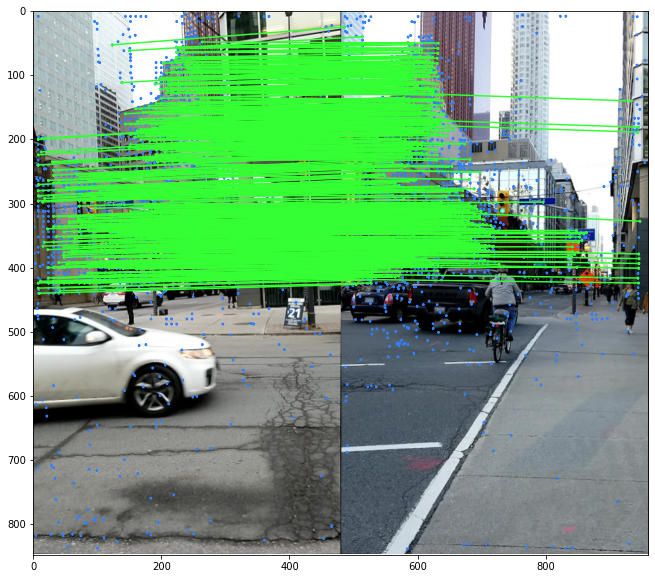

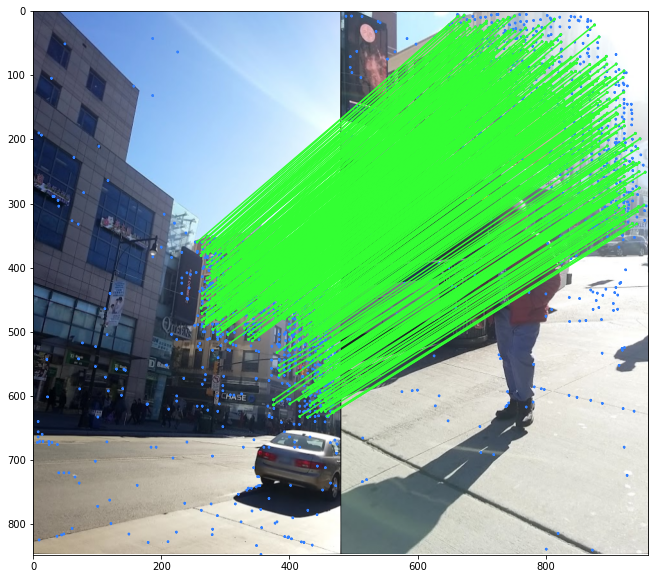

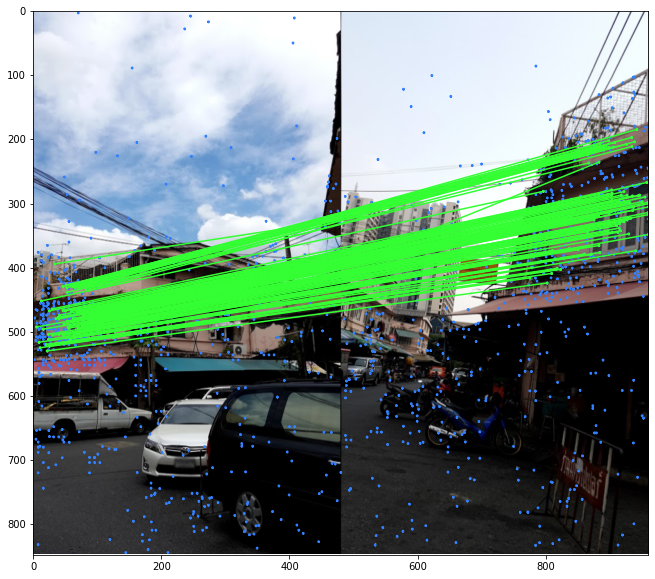

In [12]:
%matplotlib inline 

F_dict = {}

for i, row in enumerate(test_samples):
    
    # Get items
    sample_id, batch_id, image_1_id, image_2_id = row
    st = time.time()
    
    # LoFTR
    
    image_1, h1, w1 = load_torch_image(f'{src}/test_images/{batch_id}/{image_1_id}.png', device)
    image_2, h2, w2 = load_torch_image(f'{src}/test_images/{batch_id}/{image_2_id}.png', device)

    input_dict = {"image0": K.color.rgb_to_grayscale(image_1), 
              "image1": K.color.rgb_to_grayscale(image_2)}

    with torch.no_grad():
        correspondences = matcher(input_dict)
        
    mkpts0_lf = correspondences['keypoints0'].cpu().numpy()
    mkpts1_lf = correspondences['keypoints1'].cpu().numpy()
    
    # SuperGlue
    
    image_fpath_1 = f'{src}/test_images/{batch_id}/{image_1_id}.png'
    image_fpath_2 = f'{src}/test_images/{batch_id}/{image_2_id}.png'
    
    image_1_sg, inp_1, scales_1 = read_image(image_fpath_1, device, [w1, h1], 0, resize_float)
    image_2_sg, inp_2, scales_2 = read_image(image_fpath_2, device, [w2, h2], 0, resize_float)
    
    pred = matching_sg({"image0": inp_1, "image1": inp_2})
    pred = {k: v[0].detach().cpu().numpy() for k, v in pred.items()}
    kpts0, kpts1 = pred["keypoints0"], pred["keypoints1"]
    matches, conf = pred["matches0"], pred["matching_scores0"]

    valid = matches > -1
    mkpts0_sg = kpts0[valid]
    mkpts1_sg = kpts1[matches[valid]]
    
    # DKM
    
    img1 = cv2.imread(f'{src}/test_images/{batch_id}/{image_1_id}.png') 
    img2 = cv2.imread(f'{src}/test_images/{batch_id}/{image_2_id}.png')
    img1 = cv2.resize(img1, (w1, h1))
    img2 = cv2.resize(img2, (w2, h2))

    img1PIL = Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    img2PIL = Image.fromarray(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    
    dense_matches, dense_certainty = model.match(img1PIL, img2PIL, w1, h1)
    dense_certainty = dense_certainty.sqrt()
    sparse_matches, sparse_certainty = model.sample(dense_matches, dense_certainty, 300)
    
    mkps1_dkm = sparse_matches[:, :2]
    mkps2_dkm = sparse_matches[:, 2:]
    
    h, w, c = img1.shape
    mkps1_dkm[:, 0] = ((mkps1_dkm[:, 0] + 1)/2) * w
    mkps1_dkm[:, 1] = ((mkps1_dkm[:, 1] + 1)/2) * h

    h, w, c = img2.shape
    mkps2_dkm[:, 0] = ((mkps2_dkm[:, 0] + 1)/2) * w
    mkps2_dkm[:, 1] = ((mkps2_dkm[:, 1] + 1)/2) * h
    
    # ASLFeat
    
    rgb_list, gray_list = load_imgs([image_fpath_1, image_fpath_2], h1, w1)    

    descs, kpts = extract_local_features(gray_list)
    
    asl_points1, asl_points2 = asl_matcher.get_matches(descs[0], descs[1], kpts[0], kpts[1],
                                                          ratio = None, cross_check = True, err_thld = 0.20)
    
    # Keypoint concatenation
    
    mkpts0 = np.concatenate((mkpts0_lf, mkpts0_sg, mkps1_dkm, asl_points1))
    mkpts1 = np.concatenate((mkpts1_lf, mkpts1_sg, mkps2_dkm, asl_points2))
    
    # Compute fundamental matrix and get inliers
    
    if len(mkpts0) > 7:
        FM, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.2, 0.9999, 100000)
        inliers = inliers > 0
        
        # Handling broken matrixes
        
        if FM is None:
            F_dict[sample_id] = np.zeros((3, 3))
            continue
        elif FM.shape != (3, 3):
            F_dict[sample_id] = np.zeros((3, 3))
            continue
            
        F_dict[sample_id] = FM
    else:
        F_dict[sample_id] = np.zeros((3, 3))
        continue
        
    gc.collect()
    nd = time.time()   
    
    # Debug info and plots
    
    if i < 3:
        print("Running time: ", nd - st, " s")
        print(mkpts0_lf.shape, mkpts0_sg.shape, mkps1_dkm.shape, asl_points1.shape)
        draw_LAF_matches(
        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
        torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
        K.tensor_to_image(image_1),
        K.tensor_to_image(image_2),
        inliers,
        draw_dict={'inlier_color': (0.2, 1, 0.2),
                   'tentative_color': None, 
                   'feature_color': (0.2, 0.5, 1), 'vertical': False})

# Writing submission

with open('submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, FM in F_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(FM)}\n')